In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils import shuffle
import sklearn.metrics as metrics


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 預處理

In [ ]:
data = pd.read_csv("/content/drive/My Drive/dataset/Train_Test_IoT_Garage_Door.csv")
for i in range(10):
    data = shuffle(data)
#ts=date+time所以不需要
data.pop("date")
data.pop("time")
#取代空格
data = data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
"""
data["door_state"] = [i.replace(" ","") for i in data['door_state']]
data["sphone_signal"] = [i.replace(" ","") for i in data['sphone_signal']]"""
#labeling
data['door_state'] = data['door_state'].map({"closed":0,"open":1})
data['sphone_signal'] = data["sphone_signal"].map({"false":0,"true":1,"0":0 ,"1":1})

#ts正規化
# 創建 StandardScaler 物件
scaler = StandardScaler()
data["ts"]=scaler.fit_transform(data["ts"].values.reshape(-1, 1))
type_one_hot = pd.get_dummies(data["type"],prefix="type")
data.pop("type")
data = data.join(type_one_hot)

#拿出資料90%當作訓練集
par = np.random.rand(len(data)) < 0.9
data_train = data[par]
#剩下的當作test集
data_test = data[~par]

train_data = data.values
test_data = data.values
#前4列的資料進行訓練
X_train = train_data[:,0:4]
X_train=X_train.astype(float)
#第5列之後為目標變量
Y_train = train_data[:,4:]
Y_train= Y_train.astype(float)
#前4列為測試集
X_test = test_data[:,0:4]
X_test=X_test.astype(float)
#第5列之後為訓練目標變量
Y_test = test_data[:,4:]
Y_test=Y_test.astype(float)

print(data)


             ts  door_state  sphone_signal  label  type_backdoor  type_ddos  \
37607 -0.877526           0              0      0              0          0   
37143 -0.877534           0              0      0              0          0   
29772  1.223022           0              0      1              0          0   
56369 -0.790971           1              1      0              0          0   
36868 -0.877537           0              0      0              0          0   
...         ...         ...            ...    ...            ...        ...   
46249 -0.877771           0              0      0              0          0   
10367 -0.748388           0              0      0              0          0   
44783 -0.877411           0              0      0              0          0   
3318   1.340972           1              1      1              1          0   
20793 -0.748366           0              0      0              0          0   

       type_injection  type_normal  type_password  

In [ ]:
data.head(10)

,ts,door_state,sphone_signal,label,type_backdoor,type_ddos,type_injection,type_normal,type_password,type_ransomware,type_scanning,type_xss
37607,-0.877526,0,0,0,0,0,0,1,0,0,0,0
37143,-0.877534,0,0,0,0,0,0,1,0,0,0,0
29772,1.223022,0,0,1,0,0,0,0,0,0,0,1
56369,-0.790971,1,1,0,0,0,0,1,0,0,0,0
36868,-0.877537,0,0,0,0,0,0,1,0,0,0,0
22886,1.175679,0,0,1,0,0,0,0,1,0,0,0
47489,-0.877706,0,0,0,0,0,0,1,0,0,0,0
7365,1.078920,0,0,1,0,0,1,0,0,0,0,0
1393,1.337629,0,0,1,1,0,0,0,0,0,0,0
7068,1.078637,0,0,1,0,0,1,0,0,0,0,0


## KNN建置

In [ ]:
knnModel = KNeighborsClassifier(n_neighbors=3)
knnModel.fit(X_train,Y_train)
predicted= knnModel.predict(X_train)

## 預測成功的比例

In [ ]:
print('訓練集: ',knnModel.score(X_train,Y_train))
print('測試集: ',knnModel.score(X_test,Y_test))

訓練集:  1.0


KeyboardInterrupt: ignored

In [ ]:
print('R2 score: ', knnModel.score(X_test, Y_test))
mse = metrics.mean_squared_error(Y_test, predicted)
print('MSE score: ', mse)

R2 score:  1.0
MSE score:  0.0


## KFold驗證 當neighbor=3

In [ ]:
accuracy = cross_val_score(knnModel, X_test, Y_test, cv=10, scoring="accuracy")
print(accuracy)
print(accuracy.mean()*100,'%')

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
100.0 %


## 輸出混淆矩陣

In [ ]:
Y_pred = predicted

Y_pred = np.argmax(Y_pred, axis=1).astype(int)
Y_test_2 = np.argmax(Y_test, axis=1).astype(int)


from sklearn.metrics import multilabel_confusion_matrix

#row=Y_test_2 col=Y_pred
cm=confusion_matrix(Y_test_2,Y_pred)
print(cm)

[[  424   430   426  2922   399   250    45   104]
 [  394   392   416  2976   434   248    52    88]
 [  415   430   423  2959   406   234    41    92]
 [ 2968  2915  2928 20549  2933  1721   312   674]
 [  416   450   424  2883   424   242    49   112]
 [  235   247   237  1721   258   133    17    54]
 [   43    41    52   312    51    19     2     9]
 [  105    95    94   678    95    55    11    23]]


## 繪製熱力圖

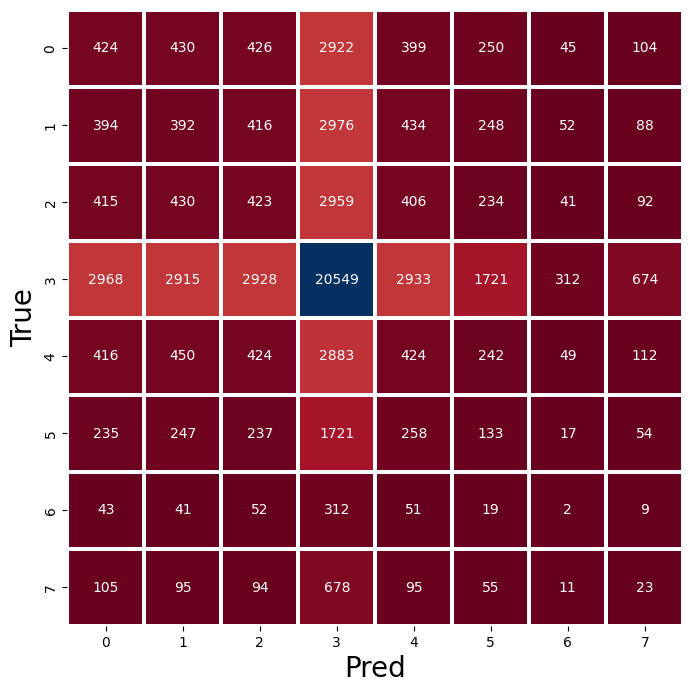

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
sns.heatmap(cm,square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
plt.xlabel('Pred',fontsize=20)
plt.ylabel('True',fontsize=20)
plt.show()

## KNN最佳值

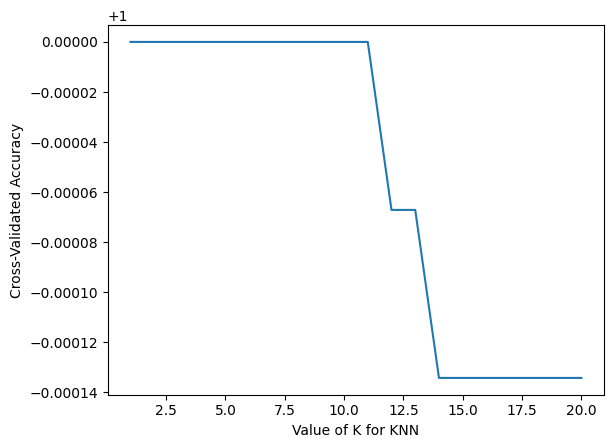

In [ ]:
k_range = range(1,21)
k_scores = []
for k_number in k_range:
    knn = KNeighborsClassifier(n_neighbors=k_number)
    scores = cross_val_score(knn,X_train,Y_train,cv=10,scoring='accuracy')
    k_scores.append(scores.mean())

plt.plot(k_range,k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()